Target:

1. Basic Set-up
2. Set Transforms
3. Set Data loader
4. Set basic working code
5. Set up training & test Loop

Results:

1. Parameters: 547k
2. Best Training Accuracy: 99.28
3. Best Test Accuracy: 99.03

Analysis:

1. Model is too heavy for the given problem and is also overfitting
2. Validation accuracy seem to decrease in later epochs

In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [22]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [23]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [24]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [25]:
torch.manual_seed(1)
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

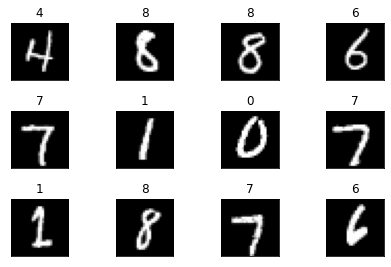

In [26]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [50]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # Input size = 28
    self.convblock1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
    ) # output_size = 26  RF = 3

    self.convblock2 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
    ) # output_size = 24  RF = 5

    self.convblock3 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
    ) # output_size = 22  RF = 7

    self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11   RF = 8
    
    self.convblock4 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
      nn.ReLU(),
    ) # output_size = 11  RF = 8


    self.convblock5 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
    ) # output_size = 9  RF = 12

    self.convblock6 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
    ) # output_size = 7  RF = 16

    self.convblock7 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
      nn.ReLU(),
    ) # output_size = 5  RF = 20

    self.convblock8 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
    ) # output_size = 1  RF = 28

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x = self.pool1(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.convblock8(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

In [51]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
    

In [52]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [53]:
def FillWrongPredictions (data, target, pred, out_dict):
  pred = pred.argmax(dim=1)
  correct_pred_indices = pred.eq(target) # list of Trues and Falses, Trues being at indices of correct predictions
  data = data.tolist()
  target = target.tolist()
  pred = pred.tolist()
  out_dict['images'] += [data[x] for x in range(len(correct_pred_indices)) if not correct_pred_indices[x]]
  out_dict['ground_truths'] += [target[x] for x in range(len(correct_pred_indices)) if not correct_pred_indices[x]]
  out_dict['predicted_vals'] += [pred[x] for x in range(len(correct_pred_indices)) if not correct_pred_indices[x]]

def DisplayWrongPredictions (data_dict):
  fig = plt.figure(figsize=(20, 20))

  for i in range(len(data_dict['images'])):
    plt.subplot(10,len(data_dict['images'])/10 + 1, i+1)
    plt.imshow(data_dict['images'][i][0], cmap='gray_r')
    plt.title(f"GT: {data_dict['ground_truths'][i]}, P: {data_dict['predicted_vals'][i]}")
    plt.xticks([])
    plt.yticks([])

In [54]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def Train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def Test(model, device, test_loader, fill_incorrect_samples):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

            if fill_incorrect_samples:
              FillWrongPredictions (data, target, output, test_incorrect_pred)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [55]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  Train(model, device, train_loader, optimizer)
  Test(model, device, test_loader, epoch == num_epochs)

Epoch 1


Train: Loss=2.3012 Batch_id=117 Accuracy=24.37: 100%|██████████| 118/118 [00:14<00:00,  7.99it/s]


Test set: Average loss: 2.3017, Accuracy: 958/10000 (9.58%)

Epoch 2


Train: Loss=2.2669 Batch_id=117 Accuracy=16.52: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Test set: Average loss: 2.2462, Accuracy: 2743/10000 (27.43%)

Epoch 3


Train: Loss=0.2820 Batch_id=117 Accuracy=67.09: 100%|██████████| 118/118 [00:12<00:00,  9.64it/s]


Test set: Average loss: 0.2752, Accuracy: 9136/10000 (91.36%)

Epoch 4


Train: Loss=0.1457 Batch_id=117 Accuracy=93.71: 100%|██████████| 118/118 [00:12<00:00,  9.12it/s]


Test set: Average loss: 0.1264, Accuracy: 9592/10000 (95.92%)

Epoch 5


Train: Loss=0.2083 Batch_id=117 Accuracy=96.35: 100%|██████████| 118/118 [00:12<00:00,  9.74it/s]


Test set: Average loss: 0.0798, Accuracy: 9749/10000 (97.49%)

Epoch 6


Train: Loss=0.0837 Batch_id=117 Accuracy=97.20: 100%|██████████| 118/118 [00:12<00:00,  9.75it/s]


Test set: Average loss: 0.0667, Accuracy: 9788/10000 (97.88%)

Epoch 7


Train: Loss=0.0720 Batch_id=117 Accuracy=97.62: 100%|██████████| 118/118 [00:12<00:00,  9.83it/s]


Test set: Average loss: 0.0777, Accuracy: 9745/10000 (97.45%)

Epoch 8


Train: Loss=0.0437 Batch_id=117 Accuracy=98.00: 100%|██████████| 118/118 [00:12<00:00,  9.47it/s]


Test set: Average loss: 0.0519, Accuracy: 9821/10000 (98.21%)

Epoch 9


Train: Loss=0.0322 Batch_id=117 Accuracy=98.30: 100%|██████████| 118/118 [00:12<00:00,  9.58it/s]


Test set: Average loss: 0.0425, Accuracy: 9855/10000 (98.55%)

Epoch 10


Train: Loss=0.0113 Batch_id=117 Accuracy=98.46: 100%|██████████| 118/118 [00:13<00:00,  9.03it/s]


Test set: Average loss: 0.0451, Accuracy: 9858/10000 (98.58%)

Epoch 11


Train: Loss=0.0495 Batch_id=117 Accuracy=98.52: 100%|██████████| 118/118 [00:12<00:00,  9.80it/s]


Test set: Average loss: 0.0427, Accuracy: 9864/10000 (98.64%)

Epoch 12


Train: Loss=0.0523 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:12<00:00,  9.74it/s]


Test set: Average loss: 0.0444, Accuracy: 9865/10000 (98.65%)

Epoch 13


Train: Loss=0.0136 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:12<00:00,  9.82it/s]


Test set: Average loss: 0.0371, Accuracy: 9871/10000 (98.71%)

Epoch 14


Train: Loss=0.0205 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:12<00:00,  9.82it/s]


Test set: Average loss: 0.0377, Accuracy: 9876/10000 (98.76%)

Epoch 15


Train: Loss=0.0131 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:12<00:00,  9.75it/s]


Test set: Average loss: 0.0308, Accuracy: 9896/10000 (98.96%)

Epoch 16


Train: Loss=0.0689 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:11<00:00,  9.86it/s]


Test set: Average loss: 0.0323, Accuracy: 9903/10000 (99.03%)

Epoch 17


Train: Loss=0.0769 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:12<00:00,  9.80it/s]


Test set: Average loss: 0.0343, Accuracy: 9889/10000 (98.89%)

Epoch 18


Train: Loss=0.0109 Batch_id=117 Accuracy=99.22: 100%|██████████| 118/118 [00:11<00:00,  9.84it/s]


Test set: Average loss: 0.0308, Accuracy: 9899/10000 (98.99%)

Epoch 19


Train: Loss=0.0836 Batch_id=117 Accuracy=99.25: 100%|██████████| 118/118 [00:13<00:00,  8.94it/s]


Test set: Average loss: 0.0311, Accuracy: 9894/10000 (98.94%)

Epoch 20


Train: Loss=0.0059 Batch_id=117 Accuracy=99.28: 100%|██████████| 118/118 [00:11<00:00,  9.84it/s]


Test set: Average loss: 0.0321, Accuracy: 9894/10000 (98.94%)



Text(0.5, 1.0, 'Test Accuracy')

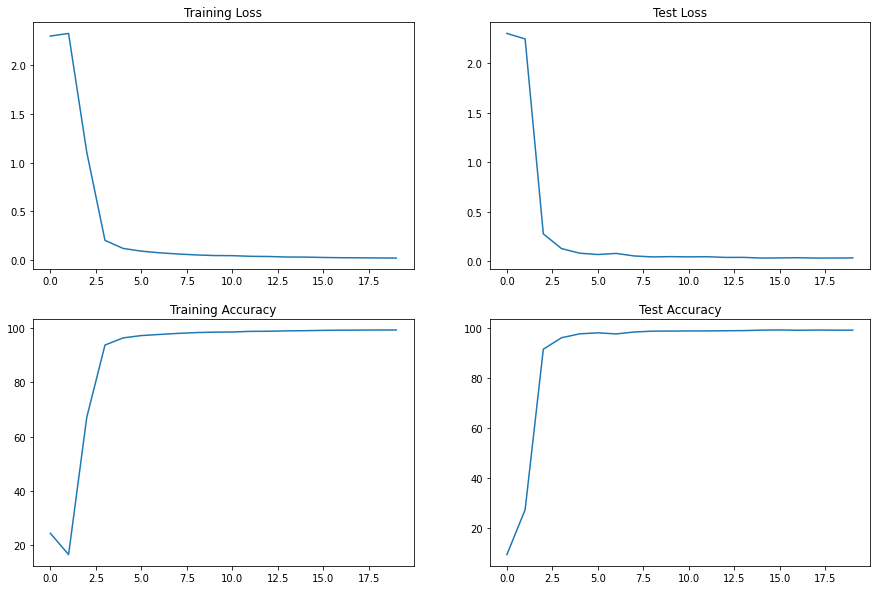

In [56]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [57]:
# From test set
#DisplayWrongPredictions (test_incorrect_pred)